In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from readFunctions import openFile
from sklearn.metrics.pairwise import cosine_similarity

In [32]:
data = openFile('../Data/All_Beauty_5.json.gz')


In [33]:
data.head()


,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,0,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,1,5.0,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,2,1.0,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,3,5.0,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,4,5.0,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN


In [18]:
print("Mean rating : {}".format(data['overall'].mean()))
print("Mean rating standard deviation: {}".format(data['overall'].std()))


Mean rating : 4.771873220724995
Mean rating standard deviation: 0.74320403799122


Text(0, 0.5, 'count of reviews')

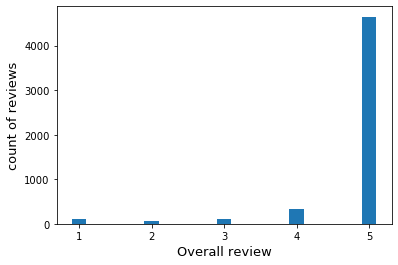

In [19]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.hist(data['overall'], bins=[0.9, 1.1, 1.9, 2.1, 2.9, 3.1, 3.9, 4.1, 4.9, 5.1])
ax.set_xlabel('Overall review', fontsize=13)
ax.set_ylabel('count of reviews', fontsize=13)


In [21]:
num_users = len(data['reviewerID'].unique())
num_items = len(data['asin'].unique())

print("Number of reviewers: {}".format(num_users))
print("Number of products : {}".format(num_items))
print("Number of ratings  : {}".format(len(data)))

avg_num_reviews = data.groupby('reviewerID')['asin'].count()
print("Avg Number of ratings per reviewer {}".format(avg_num_reviews.mean()))


Number of reviewers: 991
Number of products : 85
Number of ratings  : 5269


Text(0, 0.5, 'number of reviewers')

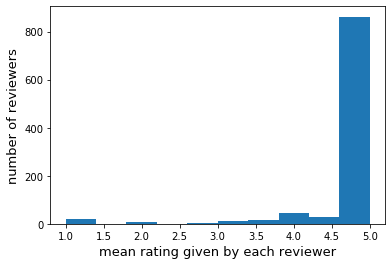

In [22]:
mean_rating_of_user = data.groupby('reviewerID').apply(lambda x: x['overall'].mean())

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each reviewer', fontsize=13)
ax.set_ylabel('number of reviewers', fontsize=13)

In [41]:
# turn each reviewer and product into categorical data,
data['reviewerID'] = data['reviewerID'].astype("category")
data['asin'] = data['asin'].astype("category")

reviews = csc_matrix((data['overall'].astype(float),
                      (data['reviewerID'].cat.codes,
                       data['asin'].cat.codes)))
print(reviews.shape)


(991, 85)


In [43]:
ratings_matrix = reviews.toarray()

sparsity = float(len(ratings_matrix.nonzero()[0]))
sparsity /= (ratings_matrix.shape[0] * ratings_matrix.shape[1])
sparsity *= 100
print("Sparsity: {:4.2f}%".format(sparsity))


Sparsity: 4.86%


In [25]:
mean_rating = data['overall'].mean()
base_rmse = np.sqrt(pow(data['overall'] - mean_rating, 2).mean())
print("RMSE = {}".format(base_rmse))




RMSE = 0.7431335085449885


## User-User Collaborative Filtering using Cosine Similarity

In [ ]:
def User_User_CF(reviews):
    """
    Obtains the RMSE error in the user-user collaborative
    filtering algorithms using all the similar users.

    :param: reviews (numpy.ndarray) : The dense user-item matrix.

    :returns: RMSE of predictions
    :rvalue: float
    """

    # Get the user-user similarity matrix
    user_user_similarity = cosine_similarity(reviews)    
    print('user user similarity', user_user_similarity.shape)

    sqdiffs = 0
    num_preds = 0

    # to protect against divide by zero issues
    eps = 1e-6

    cnt_no_sims = 0
    # loop over the users
    for user_i, u in enumerate(reviews):

        # products user HAS rated
        i_rated = np.where(u > 0)[0]

        # Get the average rating for this user
        user_avg = i_rated.mean()

        # loop over all the products that each user reviewed
        # Note: these are all the non-zero entries in the row
        for i_product in i_rated:

            # Get all the users (indices) that
            # have also reviewed this product.
            # Note: This also includes the user of interest!
            i_has_rated = np.where(reviews[:, i_product])[0]

            # remove the user (indices) of interest
            # from this column
            i_remove = np.argmin(abs(i_has_rated - user_i))
            i_others_have_rated = np.delete(i_has_rated, i_remove)

            # Get the ratings for product by the similar users,
            ratings = reviews[i_others_have_rated,
                              i_product]

            ratings -= user_avg

            # get the cosine similarity between the users
            # and other users.
            similarities = user_user_similarity[user_i,
                                                i_others_have_rated]

            # denominator of user_i's produdct prediction
            norm = np.sum(similarities)
            if norm == 0:
                cnt_no_sims += 1
                norm = eps

            # prediction of user u on product i: p_{u,i}
            predicted_rating = user_avg + np.sum(np.multiply(
                ratings.T,
                similarities)) / norm

            # actual rating by user u on product i
            actual_rating = reviews[user_i, i_product]

        # get the L2 difference in predicted and actual
        # rating for the user
        sqdiffs += pow(predicted_rating - actual_rating, 2.0)
        num_preds += 1

    # get the average of all the predictions
    rmse_cossim = np.sqrt(sqdiffs / num_preds)
    return rmse_cossim


user_all_rmse = User_User_CF(ratings_matrix)
print('User-User CF RMSE for all users:', user_all_rmse)


In [ ]:
def User_User_CF_TopN(reviews, N):
    """
    Obtains the RMSE error in the user-user collaborative
    filtering algorithms using the top N most similar users.

    :param: reviews (numpy.ndarray) : The dense user-item matrix.
    :param: N (int) : The number of the most similar users.

    :returns: RMSE of predictions
    :rvalue: float
    """

    # Get the user-user similarity matrix
    user_user_similarity = cosine_similarity(reviews)

    sqdiffs = 0
    num_preds = 0

    # to protect against divide by zero issues
    eps = 1e-6

    cnt_no_sims = 0
    # loop over the users
    for user_i, u in enumerate(reviews):

        # products user HAS rated
        i_rated = np.where(u > 0)[0]

        # Get the average rating for this user
        user_avg = i_rated.mean()

        # loop over all the products that each user reviewed
        # Note: these are all the non-zero entries in the row
        for i_product in i_rated:

            # Get all the users (indices) that
            # have also reviewed this product.
            # Note: This also includes the user of interest!
            i_has_rated = np.where(reviews[:, i_product] > 0)[0]

            # remove the user (indices) of interest
            # from this column
            i_remove = np.argmin(abs(i_has_rated - user_i))
            i_others_have_rated = np.delete(i_has_rated, i_remove)

            # Get the ratings for product by the similar users,
            ratings = reviews[i_others_have_rated,
                              i_product]

            ratings -= user_avg

            # get the cosine similarity between the users
            # and other users.
            sims = user_user_similarity[user_i,
                                        i_others_have_rated]

            # choose top N most similar users
            most_similar_users = sims[np.argsort(sims * -1)][:N]
            most_similar_ratings = ratings[np.argsort(sims * -1)][:N]

            # denominator of user_i's produdct prediction
            norm = np.sum(most_similar_users)
            if norm == 0:
                cnt_no_sims += 1
                norm = eps

            # prediction of user u on product i: p_{u,i}
            predicted_rating = user_avg + np.sum(np.multiply(
                most_similar_ratings.T,
                most_similar_users)) / norm

            # actual rating by user u on product i
            actual_rating = reviews[user_i, i_product]

        # get the L2 difference in predicted and actual
        # rating for the user
        sqdiffs += pow(predicted_rating - actual_rating, 2.0)
        num_preds += 1

    # get the average of all the predictions
    rmse_cossim = np.sqrt(sqdiffs / num_preds)
    return rmse_cossim


N_users = [1, 2, 3, 4, 5, 10, 25, 50]
top_N = [User_User_CF_TopN(ratings_matrix, i) for i in N_users]
print('top n:', top_N)


In [ ]:
# make constant vectors
user_all = []
mean_all = []
for i in range(len(N_users)):
    user_all.append(user_all_rmse)
    mean_all.append(base_rmse)

plt.figure(figsize=(8, 5))
plt.plot(N_users, top_N, 'b', label='User-User CF, Top N Users')
plt.plot(N_users, user_all, 'r', label='User-User CF, All Users')
plt.plot(N_users, mean_all, 'k', label='Mean Rating Of All Users')
plt.xlabel('N')
plt.ylabel('RMSE Error')
plt.legend()
plt.title('RMSE Error In Recommender Predictions')


